In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =1e-24

nband = 100

ng =6

ng_refs = (/ 6 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =294

vstar = 620

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /0.8 , 0.8 , 0.8 , 0.6,
     &     0.6 , 0.9/

atmosphere_profiles/mls75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

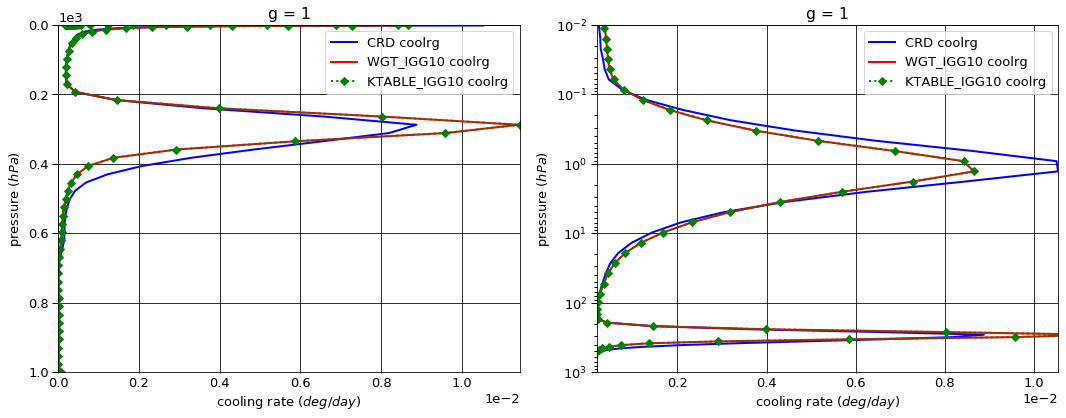

# Figure: cooling rate g-group 2

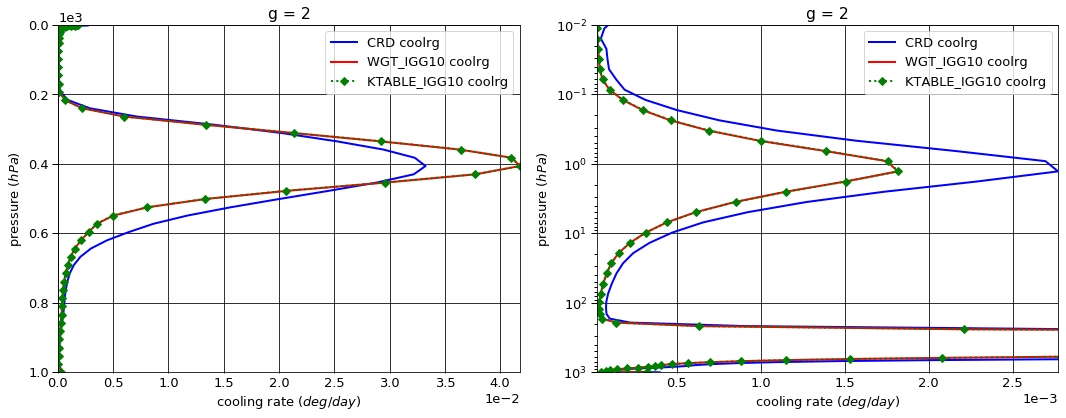

# Figure: cooling rate g-group 3

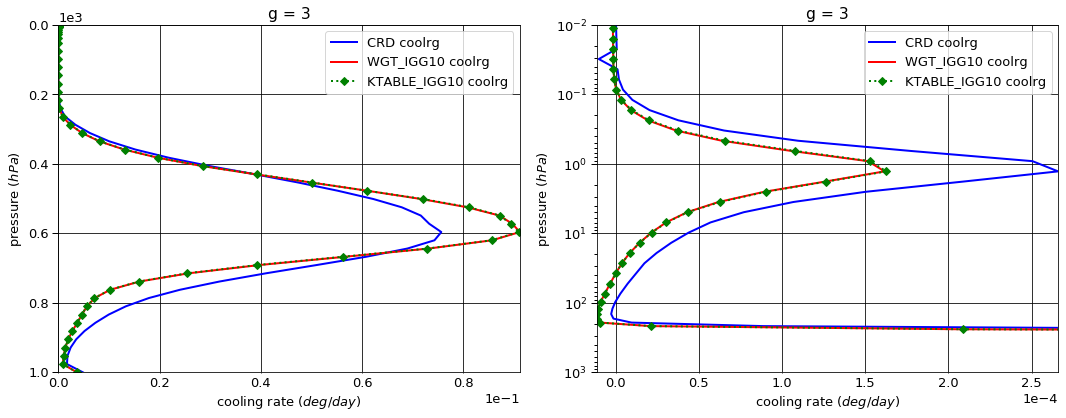

# Figure: cooling rate g-group 4

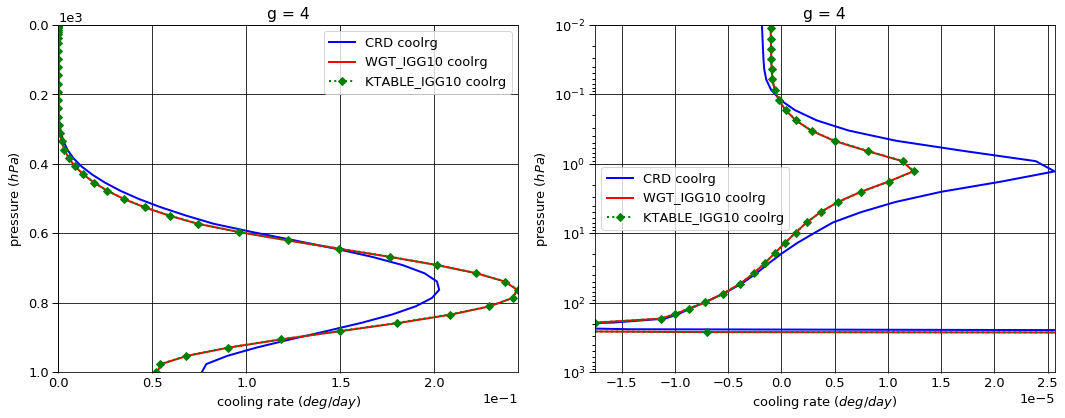

# Figure: cooling rate g-group 5

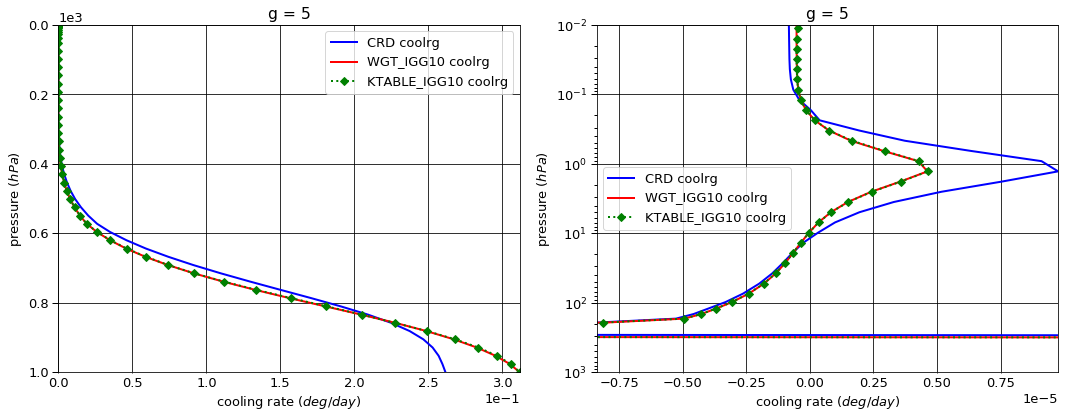

# Figure: cooling rate g-group 6

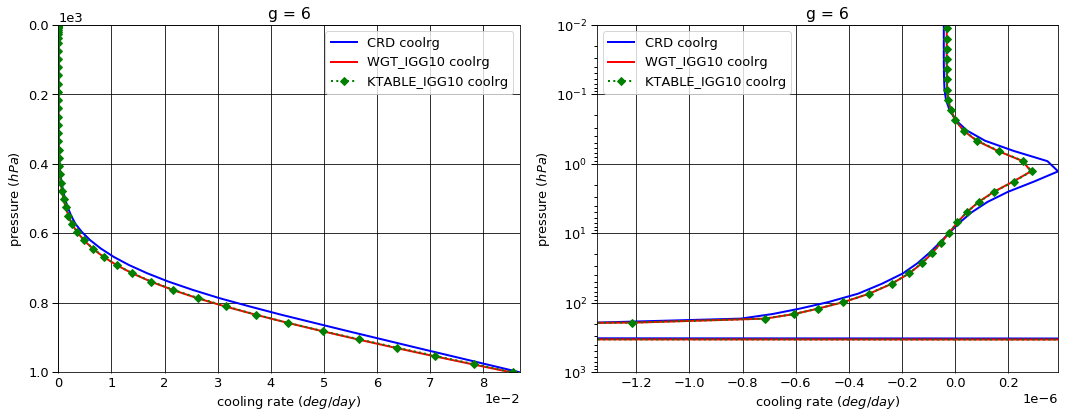

# Figure: cooling rate g-group total

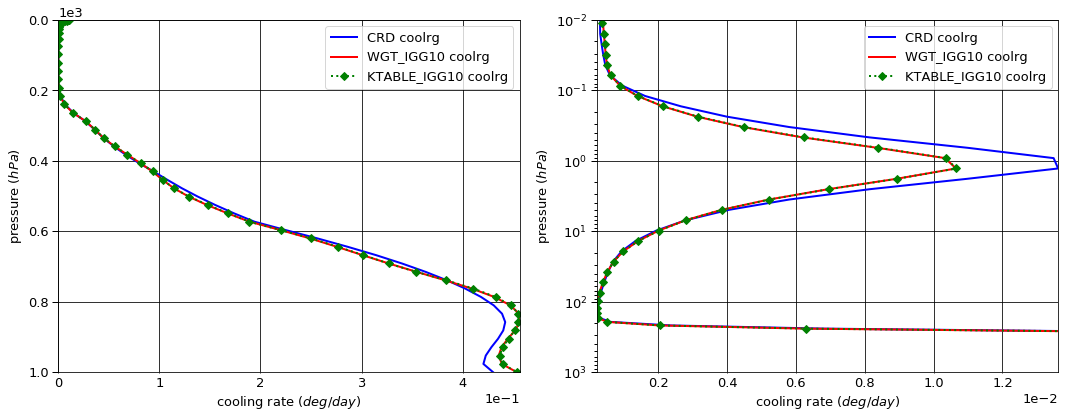

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.150709   0.000000  -0.150709
  1013.0   76     -0.333859   0.333691  -0.000168
2 0.0      1      -0.935182   0.000000  -0.935182
  1013.0   76     -1.698556   1.697504  -0.001052
3 0.0      1      -2.830706   0.000000  -2.830706
  1013.0   76     -4.092142   4.078124  -0.014018
4 0.0      1      -9.076512   0.000000  -9.076512
  1013.0   76    -10.926934  10.355979  -0.570955
5 0.0      1     -16.034464   0.000000 -16.034464
  1013.0   76    -17.098624   9.796355  -7.302268
6 0.0      1      -9.625443   0.000000  -9.625443
  1013.0   76     -9.814722   2.149115  -7.665607


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.145756   0.000000  -0.145756
  1013.0   76     -0.333859   0.333691  -0.000168
2 0.0      1      -0.911382   0.000000  -0.911382
  1013.0   76     -1.698556   1.697684  -0.000872
3 0.0      1      -2.790331   0.000000  -2.790331
  1013.0   76     -4.092142   4.082732  -0.009410
4 0.0      1      -9.061630   0.000000  -9.061630
  1013.0   76    -10.926934  10.696209  -0.230725
5 0.0      1     -16.150531   0.000000 -16.150531
  1013.0   76    -17.098624   9.738500  -7.360124
6 0.0      1      -9.650324   0.000000  -9.650324
  1013.0   76     -9.814722   1.954886  -7.859836


KTABLE_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.145703   0.000000  -0.145703
  1013.0   76     -0.333859   0.333691  -0.000168
2 0.0      1      -0.910919   0.000000  -0.910919
  1013.0   76     -1.698556   1.697684  -0.000872
3 0.0      1      -2.788586   0.000000  -2.788586
  1013.0   76     -4.092142   4.082746  -0.009397
4 0.0      1      -9.057448   0.000000  -9.057448
  1013.0   76    -10.926934  10.697935  -0.228999
5 0.0      1     -16.146554   0.000000 -16.146554
  1013.0   76    -17.098624   9.768754  -7.329870
6 0.0      1      -9.649340   0.000000  -9.649340
  1013.0   76     -9.814722   1.965597  -7.849125


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      4.952910e-03  0.000000  0.004953
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      2.380016e-02  0.000000  0.023800
  1013.0   76     0.000000e+00  0.000180  0.000180
3 0.0      1      4.037580e-02  0.000000  0.040376
  1013.0   76     0.000000e+00  0.004608  0.004608
4 0.0      1      1.488230e-02  0.000000  0.014882
  1013.0   76     0.000000e+00  0.340230  0.340231
5 0.0      1     -1.160670e-01  0.000000 -0.116067
  1013.0   76     3.552714e-15 -0.057855 -0.057856
6 0.0      1     -2.488110e-02  0.000000 -0.024881
  1013.0   76     0.000000e+00 -0.194230 -0.194230


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      5.005890e-03  0.000000  0.005006
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      2.426316e-02  0.000000  0.024263
  1013.0   76     0.000000e+00  0.000180  0.000180
3 0.0      1      4.212040e-02  0.000000  0.042120
  1013.0   76     0.000000e+00  0.004622  0.004622
4 0.0      1      1.906460e-02  0.000000  0.019065
  1013.0   76     0.000000e+00  0.341956  0.341956
5 0.0      1     -1.120900e-01  0.000000 -0.112090
  1013.0   76     3.552714e-15 -0.027602 -0.027602
6 0.0      1     -2.389700e-02  0.000000 -0.023897
  1013.0   76     0.000000e+00 -0.183518 -0.183518

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      5.442654e-05
  1001.112500 75     6.055797e-05
2 0.000312    1      2.455227e-05
  1001.112500 75     3.991249e-04
3 0.000312    1     -7.215398e-07
  1001.112500 75     4.830350e-03
4 0.000312    1     -2.113026e-06
  1001.112500 75     7.622932e-02
5 0.000312    1     -8.544040e-07
  1001.112500 75     2.616142e-01
6 0.000312    1     -4.246082e-08
  1001.112500 75     8.695903e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      2.237394e-04
  1001.112500 75     6.055797e-05
2 0.000312    1     -2.701334e-06
  1001.112500 75     3.243552e-04
3 0.000312    1     -2.017958e-06
  1001.112500 75     3.644279e-03
4 0.000312    1     -1.136091e-06
  1001.112500 75     5.248253e-02
5 0.000312    1     -5.301359e-07
  1001.112500 75     3.118084e-01
6 0.000312    1     -3.141332e-08
  1001.112500 75     8.531866e-02


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.717577e-04
  1001.112500 75     6.055797e-05
2 0.000312    1     -2.028393e-06
  1001.112500 75     3.243539e-04
3 0.000312    1     -7.378049e-07
  1001.112500 75     3.636432e-03
4 0.000312    1     -9.673527e-07
  1001.112500 75     5.212742e-02
5 0.000312    1     -3.833002e-07
  1001.112500 75     3.118678e-01
6 0.000312    1     -2.168672e-08
  1001.112500 75     8.563884e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.693128e-04
  1001.112500 75     0.000000e+00
2 0.000312    1     -2.725360e-05
  1001.112500 75    -7.476961e-05
3 0.000312    1     -1.296418e-06
  1001.112500 75    -1.186071e-03
4 0.000312    1      9.769352e-07
  1001.112500 75    -2.374679e-02
5 0.000312    1      3.242681e-07
  1001.112500 75     5.019416e-02
6 0.000312    1      1.104750e-08
  1001.112500 75    -1.640375e-03


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.173312e-04
  1001.112500 75     0.000000e+00
2 0.000312    1     -2.658066e-05
  1001.112500 75    -7.477093e-05
3 0.000312    1     -1.626505e-08
  1001.112500 75    -1.193918e-03
4 0.000312    1      1.145674e-06
  1001.112500 75    -2.410190e-02
5 0.000312    1      4.711038e-07
  1001.112500 75     5.025359e-02
6 0.000312    1      2.077410e-08
  1001.112500 75    -1.320197e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.653016,0.000000,-38.653016
1013.0,76,-43.964837,28.410769,-15.554069



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.709953,0.000000,-38.709953
1013.0,76,-43.964837,28.503702,-15.461135



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.698549,0.000000,-38.698549
1013.0,76,-43.964837,28.546406,-15.418431



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.056937,0.000000,-0.056937
1013.0,76,0.000000,0.092933,0.092934



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.045533,0.000000,-0.045533
1013.0,76,0.000000,0.135637,0.135637


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000075
1001.112500,75,0.430093



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000217
1001.112500,75,0.453639



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000168
1001.112500,75,0.453655



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000142
1001.112500,75,0.023546



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000092
1001.112500,75,0.023563


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00750,0.007722
2,0.03850,0.038815
3,0.09275,0.093538
4,0.24780,0.249559
5,0.38800,0.390004
6,0.22545,0.220362


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.620340e-21
2,2.553906e-22
3,4.025348e-23
4,6.344568e-24
5,1.000002e-24
6,1.307067e-25


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.620340e-21,NaN,0.00750,0.007722,0.00750,0.007722,600.0
2,2.553906e-22,0.157615,0.03850,0.038815,0.04600,0.046537,600.0
3,4.025348e-23,0.157615,0.09275,0.093538,0.13875,0.140075,600.0
4,6.344568e-24,0.157615,0.24780,0.249559,0.38655,0.389634,600.0
5,1.000002e-24,0.157615,0.38800,0.390004,0.77455,0.779638,600.0
6,1.307067e-25,0.130706,0.22545,0.220362,1.00000,1.000000,600.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     4.002507e-21  9.989778e-23  40.066024  2.743879e-07
      2 0.000312     1.713419e-22  3.577750e-24  47.890968  1.173428e-08
      3 0.000312     2.091495e-24  1.719173e-25  12.165704  1.454194e-10
      4 0.000312     2.870620e-25  2.338203e-26  12.277034  1.546441e-11
      5 0.000312     6.197295e-26  4.428621e-27  13.993735  3.317471e-12
      6 0.000312     3.884443e-27  4.087491e-28   9.503246  3.012042e-13
2     1 0.000750     4.028019e-21  1.000450e-22  40.262082  1.112209e-07
      2 0.000750     1.723665e-22  3.584394e-24  48.088042  4.754572e-09
      3 0.000750     2.114421e-24  1.724870e-25  12.258437  5.920604e-11
      4 0.000750     2.882523e-25  2.346587e-26  12.283895  6.254508e-12
      5 0.000750     6.239445e-26  4.445493e-27  14.035439  1.345139e-12
      6 0.000750     3.912922e-27  4.116054e-28   9.506489  1.222100e-13
3     1 0.001052     4.082710e-21  1.003182e-22  40.697590  1.580819e-07
      2 0.001052     1.745649e-22  3.596304e-24  48.540093  6.752461e-09
      3 0.001052     2.163454e-24  1.735055e-25  12.469080  8.492647e-11
      4 0.001052     2.907970e-25  2.363169e-26  12.305384  8.847871e-12
      5 0.001052     6.329842e-26  4.478996e-27  14.132281  1.913140e-12
      6 0.001052     3.973667e-27  4.173495e-28   9.521197  1.740431e-13
4     1 0.001476     4.141257e-21  1.006161e-22  41.159003  2.249367e-07
      2 0.001476     1.769199e-22  3.609514e-24  49.014889  9.600293e-09
      3 0.001476     2.216757e-24  1.746258e-25  12.694328  1.220355e-10
      4 0.001476     2.935345e-25  2.381082e-26  12.327780  1.252829e-11
      5 0.001476     6.427047e-26  4.514831e-27  14.235411  2.724256e-12
      6 0.001476     4.039012e-27  4.235737e-28   9.535559  2.481745e-13
5     1 0.002070     4.200519e-21  1.009274e-22  41.619223  3.199867e-07
      2 0.002070     1.793054e-22  3.623635e-24  49.482193  1.364615e-08
      3 0.002070     2.271630e-24  1.758116e-25  12.920821  1.753430e-10
      4 0.002070     2.963214e-25  2.399531e-26  12.349139  1.773727e-11
      5 0.002070     6.525928e-26  4.551332e-27  14.338501  3.878544e-12
      6 0.002070     4.105543e-27  4.299930e-28   9.547929  3.538148e-13
6     1 0.002904     4.260439e-21  1.012569e-22  42.075524  4.552308e-07
      2 0.002904     1.817191e-22  3.638974e-24  49.936903  1.939876e-08
      3 0.002904     2.328116e-24  1.770855e-25  13.146846  2.519940e-10
      4 0.002904     2.991573e-25  2.418669e-26  12.368677  2.511682e-11
      5 0.002904     6.626432e-26  4.588757e-27  14.440581  5.522634e-12
      6 0.002904     4.173264e-27  4.366500e-28   9.557459  5.044902e-13
7     1 0.004074     4.321004e-21  1.016118e-22  42.524647  6.476233e-07
      2 0.004074     1.841605e-22  3.655975e-24  50.372470  2.757647e-08
      3 0.004074     2.386330e-24  1.784805e-25  13.370258  3.622165e-10
      4 0.004074     3.020452e-25  2.438735e-26  12.385324  3.557088e-11
      5 0.004074     6.728601e-26  4.627518e-27  14.540411  7.864067e-12
      6 0.004074     4.242259e-27  4.436129e-28   9.562976  7.193807e-13
8     1 0.005714     4.382197e-21  1.020018e-22  42.961965  9.212183e-07
      2 0.005714     1.866290e-22  3.675270e-24  50.779673  3.919789e-08
      3 0.005714     2.446421e-24  1.800427e-25  13.588004  5.207145e-10
      4 0.005714     3.049885e-25  2.460064e-26  12.397585  5.037823e-11
      5 0.005714     6.832483e-26  4.668199e-27  14.636228  1.119786e-11
      6 0.005714     4.312640e-27  4.509791e-28   9.562838  1.025802e-12
9     1 0.008015     4.444003e-21  1.024412e-22  43.381017  1.310358e-06
      2 0.008015     1.891238e-22  3.697748e-24  51.145673  5.571652e-08
      3 0.008015     2.508593e-24  1.818370e-25  13.795833  7.487724e-10
      4 0.008015     3.079926e-25  2.483135e-26  12.403376  7.136063e-11
      5 0.008015     6.938153e-26  4.711637e-27  14.725569  1.594611e-11
      6 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
